In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon, MultiPolygon
from shapely.geometry import box
import osmnx as ox

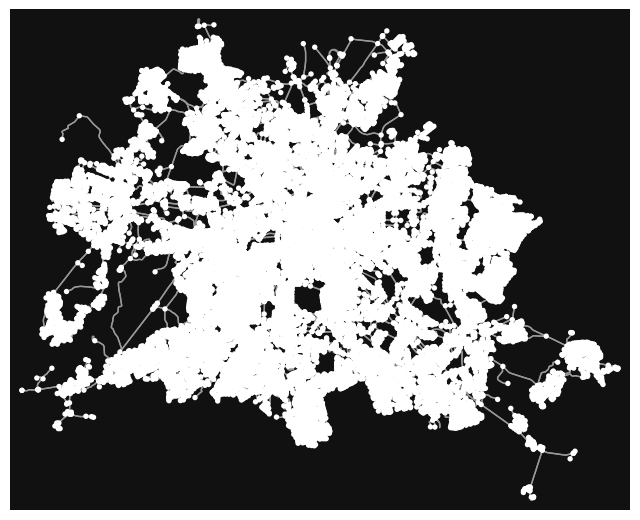

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [2]:
# Initialize the graph with the road network of Jakarta
G = ox.graph_from_place('Berlin, Germany', network_type='drive')
ox.plot_graph(G)

In [3]:
# Exporting the network to a Geopackage
ox.save_graph_geopackage(G, filepath="road_berlin.gpkg")

In [4]:
admin_district = ox.geocode_to_gdf('Berlin, Germany')
admin_poly = admin_district.geometry.values[0]

In [13]:
# Retrieve hospital data by querying OSM on the tag 'amenity=hospital.'
hospital = ox.features_from_polygon(admin_poly, tags={'amenity': 'hospital'})
hospital.to_crs(epsg=3857)
"""
Create a list to store the transformed geometries.
Because the data is inconsistent; some are in point, polygon, 
or multipolygon format, and I want to convert all of them into points.
"""
new_geometries = []

for idx, row in hospital.iterrows():
    geometry = row['geometry']
    if geometry.geom_type == 'Polygon':
        centerpoint = geometry.centroid
        new_geometries.append(centerpoint)
    elif geometry.geom_type == 'MultiPolygon':
        centerpoint = geometry.centroid
        new_geometries.append(centerpoint)
    else:
        new_geometries.append(geometry)

# Create a new GeoDataFrame with the transformed geometries.
hospital = gpd.GeoDataFrame(hospital.drop(columns='geometry'), geometry=new_geometries)

# Select the columns that will be used.
cols = ['name', 'addr:city','addr:street', 'geometry']
hospital = hospital[cols]

# Export to csv
# hospital = hospital.to_csv('hospital_jakarta.csv', index = True)

In [14]:
hospital.head()

name addr:city  \
element_type osmid                                                         
node         1257340412   Klinik für Kinder- und Jugendmedizin       NaN   
             10573646542                        Checkpoint BLN    Berlin   
way          4610129              Jüdisches Krankenhaus Berlin    Berlin   
             4637750                 DRK Kliniken Berlin Mitte    Berlin   
             4750929           Charité Campus Virchow Klinikum       NaN   

                                    addr:street                   geometry  
element_type osmid                                                          
node         1257340412                     NaN  POINT (13.37170 52.47781)  
             10573646542          Hermannstraße  POINT (13.42456 52.48584)  
way          4610129      Heinz-Galinski-Straße  POINT (13.37022 52.55545)  
             4637750         Drontheimer Straße  POINT (13.37554 52.55747)  
             4750929                        NaN  POINT (13.34351 52.54184)

In [15]:
def clean_hospital_data(hospital):
    # 1. Handle missing values
    hospital = hospital.fillna({'name': 'Unknown', 'addr:city': 'Berlin', 'addr:street': 'Unknown'})
    
    # 2. Standardize column names
    hospital = hospital.rename(columns={'addr:city': 'city', 'addr:street': 'street'})
    
    # 3. Remove duplicates
    hospital = hospital.drop_duplicates(subset=['name', 'street'], keep='first')
    
    # 4. Normalize text data
    for col in ['name', 'city', 'street']:
        hospital[col] = hospital[col].str.strip().str.title()
    
    # 5. Validate and format address information
    hospital['city'] = hospital['city'].replace({'': 'Berlin', 'berlin': 'Berlin'})

    
    # 8. Drop the geometry column as we now have lat and long
    # hospital = hospital.drop(columns='geometry')
    
    return hospital

# Apply the cleaning function to your hospital dataframe
cleaned_hospital = clean_hospital_data(hospital)

# Display the first few rows of the cleaned data
print(cleaned_hospital.head())

# Get some basic statistics about the dataset
print(cleaned_hospital.describe())

# Check for any remaining missing values
print(cleaned_hospital.isnull().sum())

                                                          name    city  \
element_type osmid                                                       
node         1257340412   Klinik Für Kinder- Und Jugendmedizin  Berlin   
             10573646542                        Checkpoint Bln  Berlin   
way          4610129              Jüdisches Krankenhaus Berlin  Berlin   
             4637750                 Drk Kliniken Berlin Mitte  Berlin   
             4750929           Charité Campus Virchow Klinikum  Berlin   

                                         street                   geometry  
element_type osmid                                                          
node         1257340412                 Unknown  POINT (13.37170 52.47781)  
             10573646542          Hermannstraße  POINT (13.42456 52.48584)  
way          4610129      Heinz-Galinski-Straße  POINT (13.37022 52.55545)  
             4637750         Drontheimer Straße  POINT (13.37554 52.55747)  
             475092

In [16]:
# Read file from Geopackage
fp = "hospital.gpkg"
cleaned_hospital.to_file(fp, driver="GPKG")


In [ ]:
import geopandas as gpd
import h3
import pandas as pd
import numpy as np
from shapely.geometry import Point, Polygon
import networkx as nx
from geopandas import GeoDataFrame
from shapely.ops import transform
import pyproj
from functools import partial